<a href="https://colab.research.google.com/github/Elangoraj/Social-network-analysis/blob/main/Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
pwd = '/content/drive/MyDrive/Networks/ia-enron.csv'

# Analyze a Network

**1.a) Load network**

In [105]:
import networkx as nx
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
from pylab import rcParams
import matplotlib.colors as mcolors#
import operator
import random as rd
!pip install powerlaw
import powerlaw
import community
from operator import itemgetter
import scipy.stats
import scipy.sparse
import scipy.sparse.csgraph
import warnings
warnings.filterwarnings("ignore")

In [106]:
fh = open(pwd, "rb")
Gx = nx.read_edgelist(fh)
fh.close()

**1.b) Adjacency Matrix**

Text(0, 0.5, 'node idx')

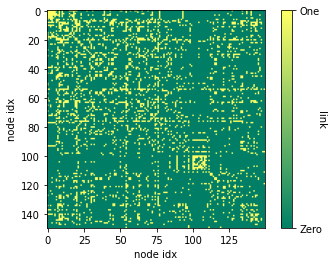

In [107]:
plt.imshow(nx.to_numpy_matrix(Gx), cmap='summer')
cbar = plt.colorbar()
cbar.set_ticks([0,1])
cbar.ax.set_yticklabels(['Zero','One'],)

cbar.set_label('link', rotation=270)
plt.xlabel('node idx')
plt.ylabel('node idx')

**1.c) Degree distribution**

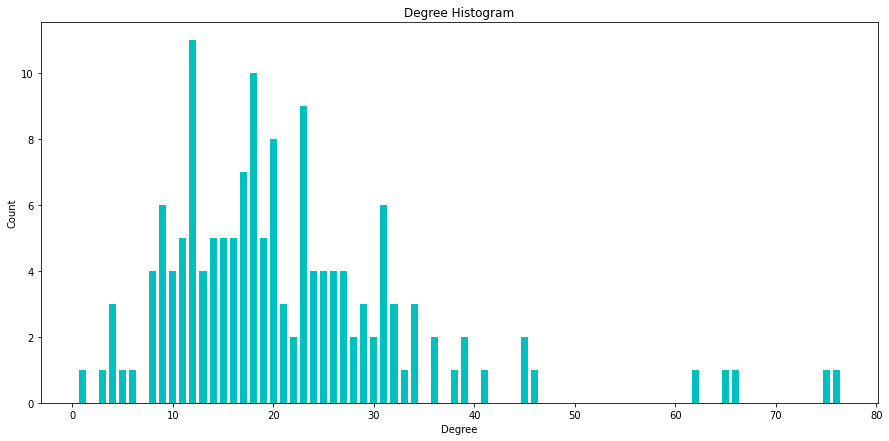

In [108]:
degree_sequence = sorted([d for n, d in Gx.degree()], reverse=True) 
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())                                       
# rcParams['figure.figsize'] = 18, 7 
plt.figure(figsize=(15,7))
plt.bar(deg, cnt, width=0.70, color='c') 

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

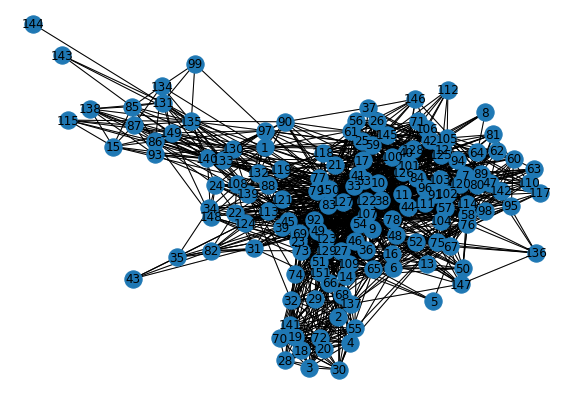

In [109]:
plt.figure(figsize=(10,7))
pos = nx.spring_layout(Gx)
plt.axis('off')
nx.draw(Gx, pos, with_labels=True)
# nx.draw_networkx_nodes(Gx,pos = pos, node_color= 'r')
nx.draw_networkx_edges(Gx,pos = pos, alpha=0.2)
plt.show()

**1.d) Kolomoropv-Smirnov test**

In [110]:
dc = list(degreeCount.values())

In [111]:
from scipy.stats import lognorm, kstest

sigma, loc, scale = lognorm.fit(dc, floc=0)

mu = np.log(scale)

print("mu    = %9.5f" % mu)
print("sigma = %9.5f" % sigma)

stat, p = kstest(dc, 'lognorm', args=(sigma, 0, scale))
print("KS Test:")
print("stat    = %9.5f" % stat)
print("p-value = %9.5f" % p)

mu    =   0.97465
sigma =   0.76074
KS Test:
stat    =   0.20226
p-value =   0.05103


**1.e) Assortative or Disassortative**

In [112]:
nx.degree_assortativity_coefficient(Gx)
# https://math.libretexts.org/Bookshelves/Scientific_Computing_Simulations_and_Modeling/Book%3A_Introduction_to_the_Modeling_and_Analysis_of_Complex_Systems_(Sayama)/17%3A_Dynamical_Networks_II__Analysis_of_Network_Topologies/17.06%3A_Assortativity

-0.04538787508087504

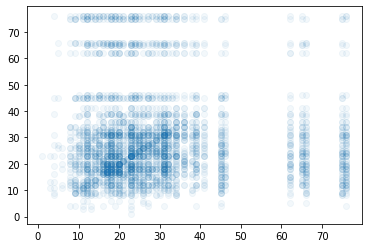

In [113]:
x = []
y = []

for i,j in Gx.edges():
  x.append(Gx.degree(i))
  y.append(Gx.degree(j))
  x.append(Gx.degree(j))
  y.append(Gx.degree(i))

plt.plot(x,y,'o',alpha=0.05)

**1.f) Fitting**

Calculating best minimal value for power law fit


alpha=  4.21041781199002   sigma=  0.7365203583688135


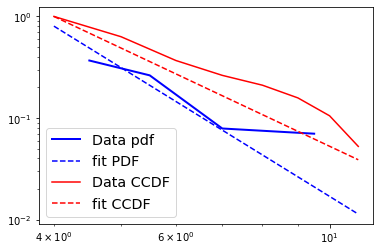

In [114]:
D = list(degreeCount.values())
D_fit = powerlaw.Fit(D)

# PDF
plot=D_fit.plot_pdf(color='b', linewidth=2)
D_fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf',ax = plot)

# CCDF
D_fit.plot_ccdf(color= 'r',ax = plot)
D_fit.power_law.plot_ccdf( color= 'r',linestyle='--',label='fit ccdf',ax = plot)

print('alpha= ',D_fit.power_law.alpha,'  sigma= ',D_fit.power_law.sigma)

plt.legend(['Data pdf', 'fit PDF', 'Data CCDF', 'fit CCDF'], fontsize = 'x-large')
plt.show()

# **2. Centrality and Community Detection**

**2.a) Centralities**

**Degree centralities:** Degree centrality defined as measurement of the number of connections owned by a node. The higher the degree, the more central the node is. Depends on the direction of the network two seperate measures of degree centrality are defined, indegree and outdegree. Count of incoming ties is the indegree and count of outgoing ties is the outdegree.

Example: Finding popular person within the class in twitter, in medical science to find degree of protein, etc.

**Eigenvector centrality:** It is measures a node’s importance while giving consideration to the importance of its neighbors. Here a node with few connections could have high eigenvector centrality if those few connections were to very well-connected nodes.

Example: Finding Influential person in the country, key author in reseach, impactful people on social media, etc.

**Difference between Degree and Eigenvector centrality:** Degree centrality awards one centrality point for every link to the node. But in eigenvector centrality a node is important if it is linked to by another important nodes. Degree centrality gives the number of relationship degree conected to the node whereas enigenvector gives the influential node in the network. In Eigenvector centrality a node receiving many links does not necessarily have a high eigenvector centrality and a node with high eigenvector centrality is not necessarily highly linked which is opposite way of degree centrality. 

**When to apply:** Usually degree centrality is used when finding highly connected, popular individual, node which can quickly connect to wider network and one which holds most information in the network. Eigenvector is used to understand human social network and understanding networks like malware propogation.  

**2.b.i) Closeness centrality**

In [115]:
adj_mat = nx.adjacency_matrix(Gx).tolil()
D = scipy.sparse.csgraph.floyd_warshall(adj_mat, directed=False, unweighted=False)
# print(D[1])

In [116]:
def closeness_Centrality(mat):
  out = {}
  # adj_mat = nx.to_numpy_matrix(graph)
  n = len(D)
  for i in range(n):
    if np.sum(mat[i])>0:
      # out.append(round((n-1)/(np.sum(mat[i])),2))
      op = (n-1)/(np.sum(mat[i]))
      out[i] = op
  return out

In [117]:
closeness_cen = closeness_Centrality(D)
# closeness_cen

In [118]:
cl_ce = nx.closeness_centrality(Gx)
# cl_ce

In [119]:
n = D.shape[0]
closeness_centrality = {}
for r in range(0, n):
    
    cc = 0.0
    
    possible_paths = list(enumerate(D[r, :]))
    shortest_paths = dict(filter( \
        lambda x: not x[1] == np.inf, possible_paths))
    
    total = sum(shortest_paths.values())
    n_shortest_paths = len(shortest_paths) - 1.0
    if total > 0.0 and n > 1:
        s = n_shortest_paths / (n - 1)
        cc = (n_shortest_paths / total) * s
    closeness_centrality[r] = cc

**2.b.ii) Comparison Centralities**

In [120]:
eg_ce = nx.eigenvector_centrality(Gx)

Correlation value between closness and eigen vector centrality = 0.9250810688678448


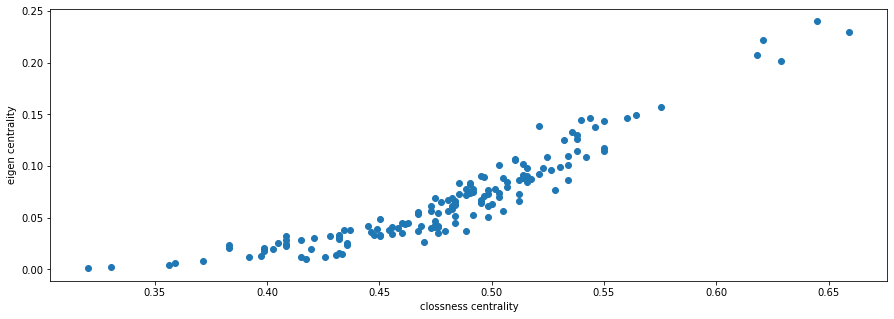

In [121]:
print('Correlation value between closness and eigen vector centrality =',scipy.stats.pearsonr(list(cl_ce.values()),list(eg_ce.values()))[0])
plt.figure(figsize=(15,5))
plt.scatter(cl_ce.values(),eg_ce.values())
plt.xlabel('clossness centrality')
plt.ylabel('eigen centrality')
plt.show()

**2.c) Centrality measure**

In [122]:
max(cl_ce.items(), key=operator.itemgetter(1)),max(eg_ce.items(), key=operator.itemgetter(1))

(('150', 0.6592920353982301), ('122', 0.23999231568820278))

In [123]:
def plot_influential_node(G,plot_graph):
  eg_ce = nx.eigenvector_centrality(G)

  print('Most influential node: ',max(eg_ce.items(), key=operator.itemgetter(1))[0])
  print('Eigen vector centrality measure: ',max(eg_ce.items(), key=operator.itemgetter(1))[1])

  if plot_graph==True:
    plt.figure(figsize=(15,10))
    pos = nx.spring_layout(G)

    nodes = nx.draw_networkx_nodes(G, pos, node_size=200, cmap='Greys', node_color=list(eg_ce.values()), nodelist=list(eg_ce.keys())) 

    max_node  = list(eg_ce.keys())[max(enumerate(eg_ce.values()), key=operator.itemgetter(1))[0]]

    nx.draw_networkx_nodes(Gx, pos, node_size=700, node_color ='black', nodelist=nx.shortest_path(G,source=max_node,target=max_node)) 

    # nodes.set_norm(mcolors.SymLogNorm(linthresh=0.03, linscale=1)) #<-- Seeting the color map of the nodes in a 

    labels = nx.draw_networkx_labels(G, pos, font_color='white') #<-- Set the node labels
    edges = nx.draw_networkx_edges(G, pos, alpha = 0.2) #<-- Set the edges pisitions

    cbar = plt.colorbar(nodes) #--> set the range of the color bar

    cbar.set_label('Eigenvector centrality     ', rotation=270) #--> Set the label of the color bar and rotate it

    plt.axis('off') #<-- Remove the axis of the network plot
    plt.show()

  return max(eg_ce.items(), key=operator.itemgetter(1))[0]

Most influential node:  122
Eigen vector centrality measure:  0.23999231568820278


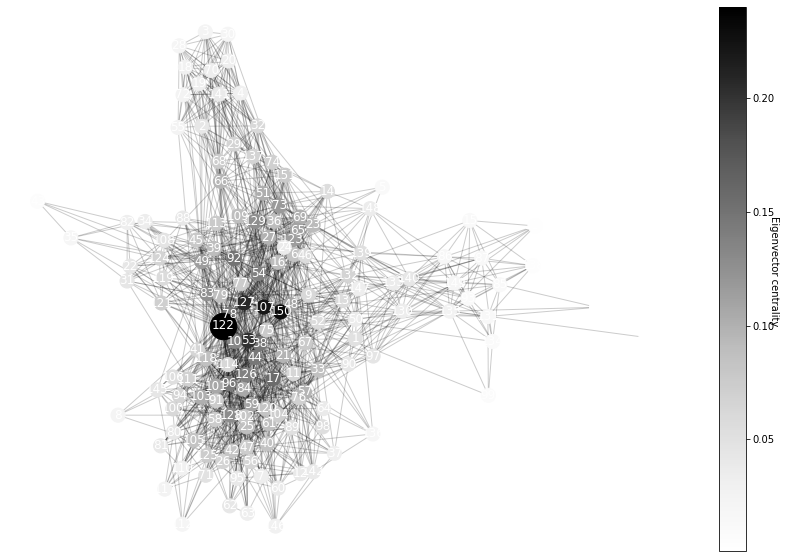

'122'

In [124]:
plot_influential_node(Gx,True)

**2.d) Influencer**

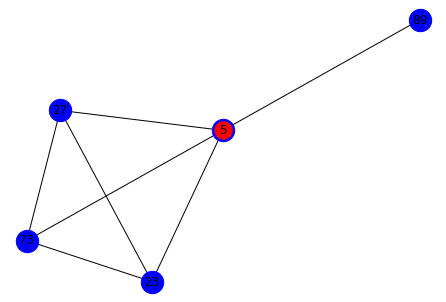

In [125]:

node_and_degree = Gx.degree()
n = '5'
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

hub_ego = nx.ego_graph(Gx, n, distance= 'weight')

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=500, with_labels=True)

# # Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=n, **options)
plt.show()

In [126]:
# dict(hub_ego.degree).values()
clusters=np.array(list(set(dict(hub_ego.degree).values())))
dict(hub_ego.degree)

{'23': 5, '27': 5, '5': 4, '73': 5, '89': 1}

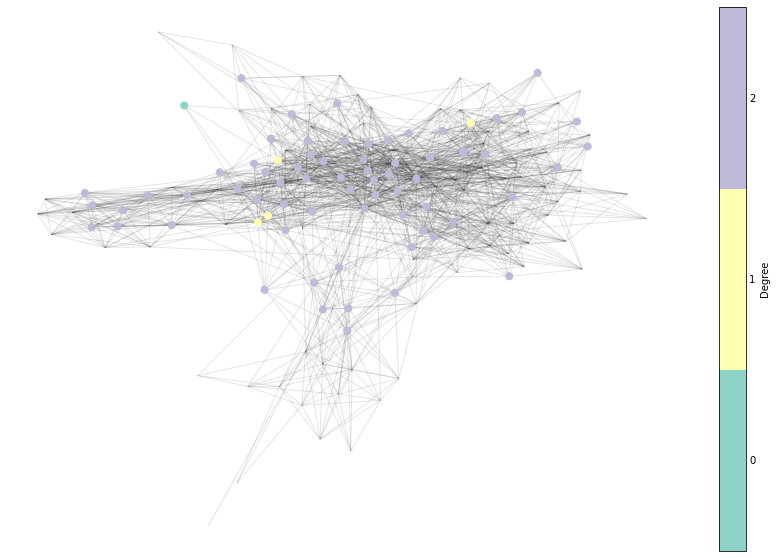

In [149]:
plt.figure(figsize=(15,10))
length=dict(nx.all_pairs_dijkstra_path_length(Gx,cutoff=2))
# print(length[1][4])
measures= length['5']
clusters = np.array(list(set(measures.values())))

# colors = [G[u][v]['color'] for u,v in clusters]

# plt.figure()
pos = nx.spring_layout(Gx)

mv = list(measures.values())

# color_map = []
# for i in range(0,len(mv)):
#   if mv[i] == 0: color_map.append('orange')
#   elif mv[i] == 1: color_map.append('g')
#   elif mv[i] == 2: color_map.append('r')
#   elif mv[i] == 3: color_map.append('b')
#   elif mv[i] == 4: color_map.append('black')

edges = nx.draw_networkx_edges(Gx, pos, alpha=0.1)

# Create the plot of the network to be placed in the figure
nodes = nx.draw_networkx_nodes(Gx, pos, node_size=50, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                                node_color=list(measures.values()),
                                nodelist=list(measures.keys()))

# # Add a colour bar to act as a legend
cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Degree')
cb.ax.tick_params(length=0)
# Adds the community labels to the colour bar
cb.set_ticklabels(list(set(measures.values())))


nodes.set_clim(-0.5, len(clusters)-0.5)

plt.axis('off')
plt.show()


In [ ]:
nx.circular_layout(Gx)

In [128]:
mv = list(measures.values())

color_map = []
for i in range(0,len(mv)):
  if mv[i] == 0: color_map.append('orange')
  elif mv[i] == 1: color_map.append('g')
  elif mv[i] == 2: color_map.append('r')
  elif mv[i] == 3: color_map.append('b')
  elif mv[i] == 4: color_map.append('black')
  else: color_map.append('yellow')

In [168]:
def Draw_ego_network(G, node_id, max_distance):
  
  n_id = "{}".format(node_id)
  hub_ego = nx.ego_graph(G, n_id, distance= 'weight')
  clusters=np.array(list(set(dict(hub_ego.degree).values())))
  plt.figure(figsize=(15,10))
  length=dict(nx.all_pairs_dijkstra_path_length(G,cutoff=max_distance))
  
  
  measures= length[n_id]
  clusters = np.array(list(set(measures.values())))

  pos = nx.spring_layout(G)

  edges = nx.draw_networkx_edges(G, pos, edge_cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), alpha=0.1)

  # Create the plot of the network to be placed in the figure
  nodes = nx.draw_networkx_nodes(G, pos, node_size=50, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                                  node_color=list(measures.values()),
                                  nodelist=list(measures.keys()))

  # # Add a colour bar to act as a legend
  cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Degree')
  cb.ax.tick_params(length=0)
  # Adds the community labels to the colour bar
  cb.set_ticklabels(list(set(measures.values())))


  nodes.set_clim(-0.5, len(clusters)-0.5)

  plt.axis('off')
  plt.show()


Most influential node:  122
Eigen vector centrality measure:  0.23999231568820278


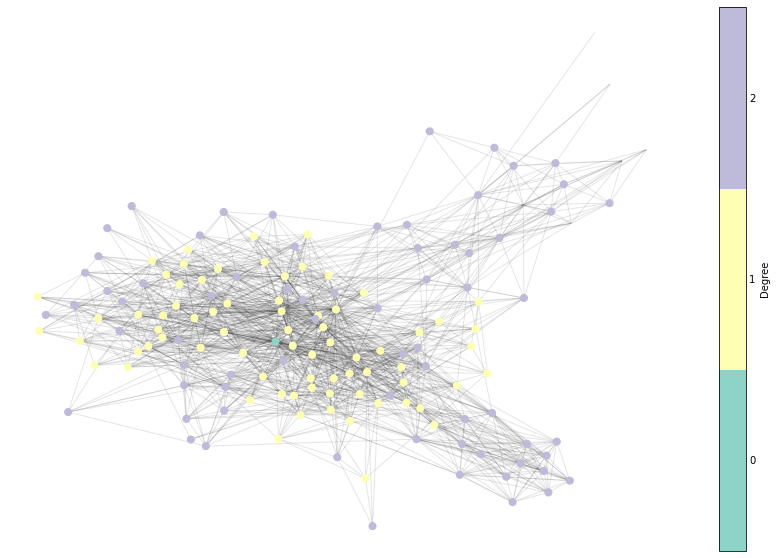

In [169]:
max_distance = 2
node_id = plot_influential_node(Gx,False)
Draw_ego_network(Gx, node_id, max_distance)

**(2.e) Community Detection and Centrality**

In [131]:
from collections import Counter, defaultdict #---> Library for operating with dictionaries
import operator #---> Library for doing maths
import seaborn as sns #---> Library for drawing plots
from matplotlib import pyplot, patches #---> Library for drawing plots


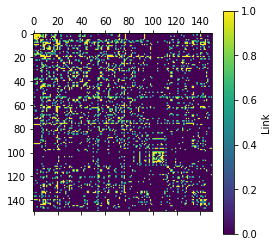

In [132]:
adj = nx.to_numpy_matrix(Gx)
plt.matshow(adj,interpolation=None)
plt.colorbar(label='Link')

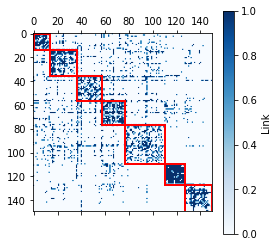

In [133]:

bp = community.best_partition(Gx)
ov = []
for k, v in (Counter(bp.values())).items():
  ov.append([k,v])

ov = sorted(ov, key=operator.itemgetter(1), reverse=True)
nov = [k[0] for k in ov]

tx = {}
for i, j in bp.items():
  tx[i] = nov.index(j)

lo = defaultdict(list)
for i, j in tx.items():
  lo[j].append(i)

lo = lo.values()

loc = [n for c in lo for n in c]
adj = nx.to_numpy_matrix(Gx, nodelist=loc)
plt.matshow(adj,interpolation=None, cmap = plt.cm.Blues)
plt.colorbar(label='Link')

split = [lo]
colours = ['r']

ax = plt.gca()

for split, color in zip(split, colours):
  idx = 0 
  for m in split:
    ax.add_patch(patches.Rectangle((idx,idx),len(m),len(m),facecolor="none", edgecolor = color,linewidth="2"))
    idx += len(m)

In [134]:
def draw_clu(G, pos, measures, measure_name):
  
    # Create an array to contain the clusters which have been found
    clusters=np.array(list(set(measures.values())))

    # Create a figure to draw the plots and charts
    plt.figure()

    # Create the plot of the network to be placed in the figure
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                                   node_color=list(measures.values()),
                                   nodelist=list(measures.keys()))


    # Add labels to the plot
    labels = nx.draw_networkx_labels(G, pos)

    # Add edges to the plot
    edges = nx.draw_networkx_edges(G, pos)

    # Create the title of the plot
    plt.title(measure_name)

    # Add a colour bar to act as a legend
    cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Communities')
    cb.ax.tick_params(length=0)
    # Adds the community labels to the colour bar
    cb.set_ticklabels(list(set(measures.values())))


    nodes.set_clim(-0.5, len(clusters)-0.5)

    # Show the plot without the x/y axis
    plt.axis('off')
    plt.show()

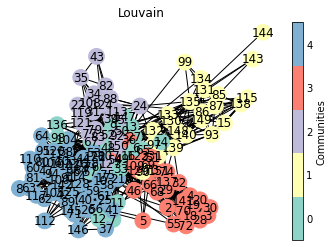

In [135]:
draw_clu(Gx, nx.spring_layout(Gx), community.best_partition(Gx), 'Louvain')

**2.f) Longest Shortest Path**

In [165]:
path = dict(nx.all_pairs_dijkstra_path(G))
max_path = []
for i in (list(path.keys())):
  max_path.append((i,max(path[i].items(), key=operator.itemgetter(1))[0],max(path[i].items(), key=operator.itemgetter(1))[1]))
source=max(max_path,key=itemgetter(2))[0]  
target=max(max_path,key=itemgetter(2))[1] 
nx.shortest_path(G,source=source,target=target)

['99', '150', '98']

In [166]:
def plot_long_shortest(G):

  path = dict(nx.all_pairs_dijkstra_path_length(G))

  max_path = []
  for i in (list(path.keys())):
    max_path.append((i,max(path[i].items(), key=operator.itemgetter(1))[0],max(path[i].items(), key=operator.itemgetter(1))[1]))

  source=max(max_path,key=itemgetter(2))[0]  #<-- Source node
  target=max(max_path,key=itemgetter(2))[1]  #<-- Target node

  pos = nx.spring_layout(G) #<-- Set the layout of the network
  nx.draw_networkx_nodes(G,pos,node_color='k',node_size=30, label=True) #<-- Plot the original network in black
  nx.draw_networkx_edges(G, pos, alpha=0.1)

  # s = "{}".format(source)
  # t = "{}".format(target)

  path = nx.shortest_path(G,source=source,target=target) #<-- Select the nodes in the shortest path
  print(path)
  path_edges = list(zip(path,path[1:])) #<-- Create a list of iterables with the edges of the shortest path
  nx.draw_networkx_nodes(G,pos,nodelist=path,node_color='g', label=True, node_size=100)  #<-- Plot the nodes
  nx.draw_networkx_edges(G,pos,edgelist=path_edges,edge_color='g',width=7)  #<-- Plot the edges
  plt.show()

['151', '66', '53', '135', '144']


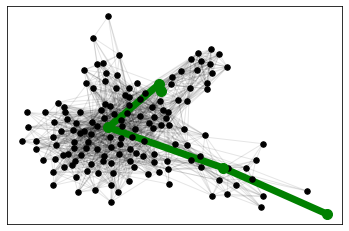

In [167]:
plot_long_shortest(Gx)

In [138]:
# draw(DiG, dpos, nx.katz_centrality(DiG, alpha=0.1, beta=1.0), 'DiGraph Katz Centrality')

# 3) SI Model

**3.a) SI Model**

In [139]:
def SI_model(G, initial_infecteds , beta, t_simulation):

  initialNodesInfected = initial_infecteds
  population = len(Gx.nodes())  # how many nodes
  beta = beta  # infection rate
  recoveryTime = 15  # how long a node stays 'recovered', not used if gamma is 0

  sData = []  # susceptible data
  infectedData = []  # infected data
  timeList = []  # time data (0 to time)

  def getInfected(graph):
      return [x for x,y in graph.nodes(data=True) if y['infected'] == 1 and y['recovered'] == False]

  def getNeighbors(graph, givenNode):
      return [x for x in graph.neighbors(givenNode)]

  # switch between the three graphs
  graphToUse = G

  # accessing nodes
  nodes = graphToUse.nodes()

  # setting initial conditions
  for node in nodes:
    if int(node) in initialNodesInfected:
        graphToUse.nodes[node]['infected'] = True
    else:
        graphToUse.nodes[node]['infected'] = False
    graphToUse.nodes[node]['recovered'] = False
    graphToUse.nodes[node]['recoveryTime'] = 0

  for t in range(t_simulation):
    # adding the time t
    timeList.append(t)

    # infecting nodes
    infected = getInfected(graphToUse)
    for j in infected:
        neighbors = getNeighbors(graphToUse, j)
        for n in neighbors:
            rand = rd.random()
            if rand <= beta:
                graphToUse.nodes[n]['infected'] = True

    # recording s(t), x(t), r(t)
    infected = getInfected(graphToUse)
    infectedData.append(len(infected))
    sData.append(population - len(infected))
    
    pos = nx.spring_layout(G)

    # if t in (10,50,100):
    #   color_map = []
    #   for iteration in (list(G.nodes())):
    #       color_map.append('green')
    #   print('Day number:',t)
    #   print(len(infected))
    #   for i in (infected):
    #     if int(i)<116:  color_map[int(i)-1] = 'red'
    #     else:   
    #       color_map[int(i)-2] = 'red'

    #   nx.draw(G, pos, node_color=color_map, with_labels=True)
    #   plt.show()

  
  plt.plot(timeList, sData, label="S")
  plt.plot(timeList, infectedData, label="I")
  plt.legend()
  plt.show()

  return sData, infectedData


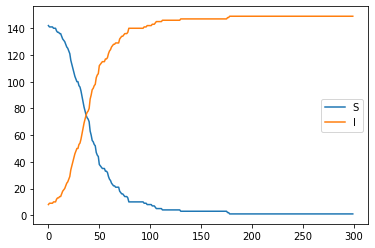

In [140]:
G = Gx
initial_infecteds = [10,15,20,25,30,35,40,45]
beta = 0.005
t_simulation = 300
SI_Suscetible, SI_Infected = SI_model(G, initial_infecteds , beta, t_simulation)

**3.b) SIR Model**

In [141]:
def SIR_model(G, initial_infecteds , beta, t_simulation, recoveryTime):

  population = len(Gx.nodes())  # how many nodes
  beta = beta  # infection rate
  # gamma = 1/recoveryTime  # recovery rate, set to 0 for a SI model
  # recoveryTime = recoveryTime  # how long a node stays 'recovered', not used if gamma is 0

  sData = []  # susceptible data
  sData_SIR = []
  infectedData = []  # infected data
  recoveredData = [] 
  timeList = []  # time data (0 to time)

  def getInfected(graph):
      return [x for x,y in graph.nodes(data=True) if y['infected'] == 1 and y['recovered'] == False]

  def getNeighbors(graph, givenNode):
      return [x for x in graph.neighbors(givenNode)]
  
  def getRecovered(graph):
    return [x for x,y in graph.nodes(data=True) if y['recovered'] == True]

  # switch between the three graphs
  graphToUse = G

  # accessing nodes
  nodes = graphToUse.nodes()

  initial_infecteds_nodes = random.sample(list(graphToUse.nodes()),initial_infecteds)

  initialNodesInfected = []
  for r in range(len(initial_infecteds_nodes)):
    initialNodesInfected.append(int(initial_infecteds_nodes[r]))

  # setting initial conditions
  for node in nodes:
    if int(node) in initialNodesInfected:
        graphToUse.nodes[node]['infected'] = True
    else:
        graphToUse.nodes[node]['infected'] = False
    graphToUse.nodes[node]['recovered'] = False
    graphToUse.nodes[node]['recoveryTime'] = 0

  for t in range(t_simulation):
    # adding the time t
    timeList.append(t)

    # infecting nodes
    infected = getInfected(graphToUse)
    for j in infected:
        neighbors = getNeighbors(graphToUse, j)
        for n in neighbors:
            rand = rd.random()
            if rand <= beta:
                graphToUse.nodes[n]['infected'] = True


    for k in infected:

      if graphToUse.nodes[k]['recoveryTime'] >= recoveryTime:
        graphToUse.nodes[k]['recovered'] = True
      graphToUse.nodes[k]['recoveryTime'] += 1
     
    infected = getInfected(graphToUse)
    infectedData.append(len(infected))
    recovered = getRecovered(graphToUse)
    recoveredData.append(len(recovered))
    sData.append(population - len(infected))
    sData_SIR.append(population - len(infected) - len(recovered))

    pos = nx.spring_layout(G)

    # if t in (2,30,50):
    #   color_map = []
    #   for iteration in (list(G.nodes())):
    #       color_map.append('b')
    #   print('Day number:',t)
    #   print('Infected node count:',len(infected))
    #   print('Recovered node count:',len(recovered))
    #   for i in (infected):
    #     if int(i)<116:  color_map[int(i)-1] = 'r'
    #     else:   
    #       color_map[int(i)-2] = 'r'
    #   for i in (recovered):
    #     if int(i)<116:  color_map[int(i)-1] = 'g'
    #     else:   
    #       color_map[int(i)-2] = 'g'

    #   nx.draw(G, pos, node_color=color_map, with_labels=True,alpha = 0.2)
    #   plt.show()


  plt.plot(timeList, sData_SIR, label="SIR Suscetible")
  plt.plot(timeList, infectedData, label="SIR Infected", color='r')
  plt.plot(timeList, recoveredData, label="SIR Recovered")
  plt.legend()
  plt.show()
  return sData_SIR, infectedData, recoveredData


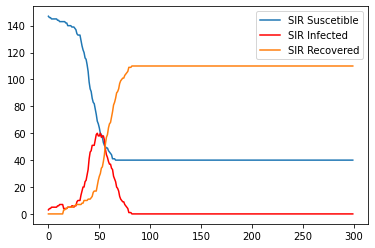

In [142]:
G = Gx
initial_infecteds = 3 # [10,15,20,25,30,35,40,45]
beta = 0.005
t_simulation = 300
recoveryTime = 15
SIR_Suscetible, SIR_infected, SIR_recovered = SIR_model(G, initial_infecteds , beta, t_simulation, recoveryTime)

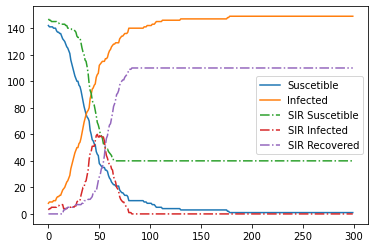

In [143]:
# SIR_Suscetible, SIR_infected, SIR_recovered
# SI_Suscetible, SI_Infected
timeList = np.arange(0,t_simulation)
plt.plot(timeList, SI_Suscetible, label="Suscetible")
plt.plot(timeList, SI_Infected, label="Infected")
plt.plot(timeList, SIR_Suscetible, label="SIR Suscetible", linestyle='-.')
plt.plot(timeList, SIR_infected, label="SIR Infected", linestyle='-.')
plt.plot(timeList, SIR_recovered, label="SIR Recovered", linestyle='-.')
plt.legend()
plt.show()

In [144]:
def Second_wave(G, initial_infecteds , beta, t_simulation, recoveryTime, new_infections):

  population = len(Gx.nodes())  # how many nodes
  beta = beta  # infection rate
  # gamma = 1/recoveryTime  # recovery rate, set to 0 for a SI model
  # recoveryTime = recoveryTime  # how long a node stays 'recovered', not used if gamma is 0

  sData = []  # susceptible data
  sData_SIR = []
  infectedData = []  # infected data
  recoveredData = [] 
  timeList = []  # time data (0 to time)

  def getInfected(graph):
      return [x for x,y in graph.nodes(data=True) if y['infected'] == 1 and y['recovered'] == False]

  def getNeighbors(graph, givenNode):
      return [x for x in graph.neighbors(givenNode)]
  
  def getRecovered(graph):
    return [x for x,y in graph.nodes(data=True) if y['recovered'] == True]

  # switch between the three graphs
  graphToUse = G

  # accessing nodes
  nodes = graphToUse.nodes()

  initial_infecteds_nodes = random.sample(list(graphToUse.nodes()),initial_infecteds)

  initialNodesInfected = []
  for r in range(len(initial_infecteds_nodes)):
    initialNodesInfected.append(int(initial_infecteds_nodes[r]))

  # setting initial conditions
  for node in nodes:
    if int(node) in initialNodesInfected:
        graphToUse.nodes[node]['infected'] = True
    else:
        graphToUse.nodes[node]['infected'] = False
    graphToUse.nodes[node]['recovered'] = False
    graphToUse.nodes[node]['recoveryTime'] = 0

  for t in range(t_simulation):

    timeList.append(t)

    if t<100:
      # infecting nodes
      infected = getInfected(graphToUse)
      for j in infected:
          neighbors = getNeighbors(graphToUse, j)
          for n in neighbors:
              rand = rd.random()
              if rand <= beta:
                  graphToUse.nodes[n]['infected'] = True

      for k in infected:

        if graphToUse.nodes[k]['recoveryTime'] >= recoveryTime:
          graphToUse.nodes[k]['recovered'] = True
        graphToUse.nodes[k]['recoveryTime'] += 1

    elif t>=100:
      infected = getInfected(graphToUse)

      if t == 100:
        sus = []
        for i in graphToUse.nodes():
          if graphToUse.nodes[i]['infected']==False: # (graphToUse.nodes[i]['infected']==True and graphToUse.nodes[i]['recovered']==True) or
            sus.append(i)
        if new_infections > len(sus):
          new_infected_nodes = random.sample(sus,len(sus))
        else:  
          new_infected_nodes = random.sample(sus,new_infections)

        new_infected = []
        for r in range(len(new_infected_nodes)):
          new_infected.append(int(new_infected_nodes[r]))

        # setting new infection conditions
        for node in nodes:
          if int(node) in new_infected:
              graphToUse.nodes[node]['infected'] = True
              graphToUse.nodes[node]['recovered'] = False
              graphToUse.nodes[node]['recoveryTime'] = 0

        for k in infected:
          graphToUse.nodes[k]['recoveryTime'] = 0
        

      for j in infected:
        neighbors = getNeighbors(graphToUse, j)
        for n in neighbors:
            rand = rd.random()
            if rand <= beta:
                graphToUse.nodes[n]['infected'] = True

      for k in infected:
        if graphToUse.nodes[k]['recoveryTime'] >= recoveryTime:
          graphToUse.nodes[k]['recovered'] = True
        graphToUse.nodes[k]['recoveryTime'] += 1


    infected = getInfected(graphToUse)
    infectedData.append(len(infected))
    recovered = getRecovered(graphToUse)
    recoveredData.append(len(recovered))
    sData.append(population - len(infected))
    sData_SIR.append(population - len(infected) - len(recovered))

  plt.plot(timeList, sData_SIR, label="SW Suscetible")
  plt.plot(timeList, infectedData, label="SW Infected")
  plt.plot(timeList, recoveredData, label="SW Recovered")
  plt.legend()
  plt.show()
  return sData_SIR, infectedData, recoveredData


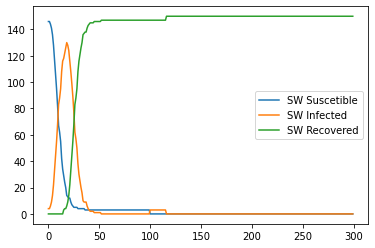

In [171]:
G = Gx
initial_infecteds = 3
beta = 0.02
t_simulation = 300
recoveryTime = 15
new_infections = 30
SW_Suscetible, SW_infected, SW_recovered = Second_wave(G, initial_infecteds , beta, t_simulation, recoveryTime, new_infections)

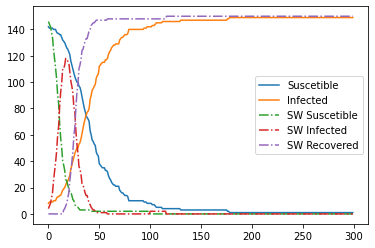

In [146]:
timeList = np.arange(0,t_simulation)
plt.plot(timeList, SI_Suscetible, label="Suscetible")
plt.plot(timeList, SI_Infected, label="Infected")
plt.plot(timeList, SW_Suscetible, label="SW Suscetible", linestyle='-.')
plt.plot(timeList, SW_infected, label="SW Infected", linestyle='-.')
plt.plot(timeList, SW_recovered, label="SW Recovered", linestyle='-.')
plt.legend()
plt.show()

In [147]:
Gx.nodes[i]

{'infected': True, 'recovered': True, 'recoveryTime': 16}